# Libraries

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import json

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor


# Load Data

In [68]:
with open("data/watch-history.json", "r", encoding="utf-8") as file:
    raw_data = json.load(file)

df = pd.DataFrame(raw_data)
df.tail()

,header,title,titleUrl,subtitles,time,products,activityControls,description,details
42448,YouTube,Watched Wellerman (Sea Shanty) but it's Pirate...,https://www.youtube.com/watch?v=tiWX0x1wk68,"[{'name': 'LittleVMills', 'url': 'https://www....",2021-06-03T12:11:09.990Z,[YouTube],[YouTube watch history],NaN,NaN
42449,YouTube,Watched WELLERMAN (Sea Shanty) METAL COVER by ...,https://www.youtube.com/watch?v=Oqr9Iq-LEVY,"[{'name': 'Jonathan Young', 'url': 'https://ww...",2021-06-03T12:10:32.001Z,[YouTube],[YouTube watch history],NaN,NaN
42450,YouTube,Watched Wellerman,https://www.youtube.com/watch?v=UNVFEt5vkWc,"[{'name': 'The Longest Johns - Topic', 'url': ...",2021-06-03T12:08:53.024Z,[YouTube],[YouTube watch history],NaN,NaN
42451,YouTube,Watched Nathan Evans - Wellerman (Sea Shanty),https://www.youtube.com/watch?v=qP-7GNoDJ5c,"[{'name': 'NathanEvansVEVO', 'url': 'https://w...",2021-06-03T12:08:18.626Z,[YouTube],[YouTube watch history],NaN,NaN
42452,YouTube,Watched Twitch Hates Them: The Top 10 Banned S...,https://www.youtube.com/watch?v=mVB-psZOX2g,"[{'name': 'theScore esports', 'url': 'https://...",2021-06-03T11:57:44.719Z,[YouTube],[YouTube watch history],NaN,NaN


# Data Cleaning

In [69]:
# Convert time to datetime
df['time'] = pd.to_datetime(df['time'], format='ISO8601')

# Remove the 'Watched' prefix from the titles
df['clean_title'] = df['title'].str.replace('Watched ', '', regex=False)

# Extract the channel name buried in the subtitles column
def extract_channel(subtitles_entry):
    # Check if valid entry
    if isinstance(subtitles_entry, list) and len(subtitles_entry) > 0:
        return subtitles_entry[0].get('name', 'Unknown')
    return 'Unknown'
df['channel_name'] = df['subtitles'].apply(extract_channel)


# Drop rows where either:
# # channel name is unknown (most likely deleted channels)
# # title is missing (most likely privated videos)
df = df[df['channel_name'] != 'Unknown'].dropna(subset=['clean_title'])


print(f"Total videos after cleaning: {len(df)}")
df[['clean_title', 'channel_name']].sample(5)

Total videos after cleaning: 38167


,clean_title,channel_name
23479,"Parabol, dört soru tipi. AYT Matematik (1)",Aranıp Bulunamayan Matematik Soruları
41093,Archspire - The Plague of AM [Fretless Bass Co...,Linden Poirier
27065,Archspire - Bleed the Future | Instrumental Re...,Bunsen Backtracks
32435,Längstmedån,Vildhjarta - Topic
2993,A Modpack We Might Regret - Nomifactory - Stre...,Zahait


# Guess Channel from Title (Naive Bayes)

## Prepare Data

In [70]:
# We cannot do ALL the channels I've watched, that's too many classes
# also there would be a lot of channels where I've watched only 1-2 videos from
# Instead, do classification on top 10 channels

TOP_N = 15
top_channels = df['channel_name'].value_counts().head(TOP_N).index

# get rows of only these top channels
df_nb = df[df['channel_name'].isin(top_channels)].copy()

print(f"Data shape for ML: {df_nb.shape}")

print("Classes to predict:")
print("-" * 20)
for i, channel in enumerate(top_channels, 1):
    print(f"{i}. {channel}")

Data shape for ML: (3379, 11)
Classes to predict:
--------------------
1. HealthyGamerGG
2. Extreme Vocal Institute
3. Jaynoo
4. theScore esports
5. Nik Nocturnal
6. CohhCarnage
7. Linus Tech Tips
8. Dean Lamb
9. Chris Liepe
10. Rudy Ayoub
11. Blaidan but less cool
12. JC & Em Streams
13. aloyark
14. Fireship
15. BERNTH


## Test and Train Naive Bayes

In [71]:
# X (features), y (targets)
X = df_nb['clean_title']
y = df_nb['channel_name']
print(f"Dataset size: {len(X)}")

# 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print()

# vectorize words
# stop_words removes common words like "the", "and", "is"
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# train
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# predictions
y_pred = model.predict(X_test_vec)

# evaluate
print("Model Accuracy Score:", model.score(X_test_vec, y_test))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Dataset size: 3379
Train set size: 2703
Test set size: 676

Model Accuracy Score: 0.8195266272189349

Classification Report:

                         precision    recall  f1-score   support

                 BERNTH       0.95      0.49      0.64        39
  Blaidan but less cool       0.97      0.90      0.93        39
            Chris Liepe       0.90      0.88      0.89        41
            CohhCarnage       1.00      0.99      0.99        67
              Dean Lamb       0.86      0.80      0.83        45
Extreme Vocal Institute       0.82      0.98      0.89        60
               Fireship       0.82      0.58      0.68        24
         HealthyGamerGG       0.66      0.98      0.78        82
        JC & Em Streams       0.95      1.00      0.97        36
                 Jaynoo       0.69      0.94      0.80        35
        Linus Tech Tips       0.81      0.69      0.74        42
          Nik Nocturnal       0.79      0.89      0.84        47
             Rudy Ayoub     

## Visualization

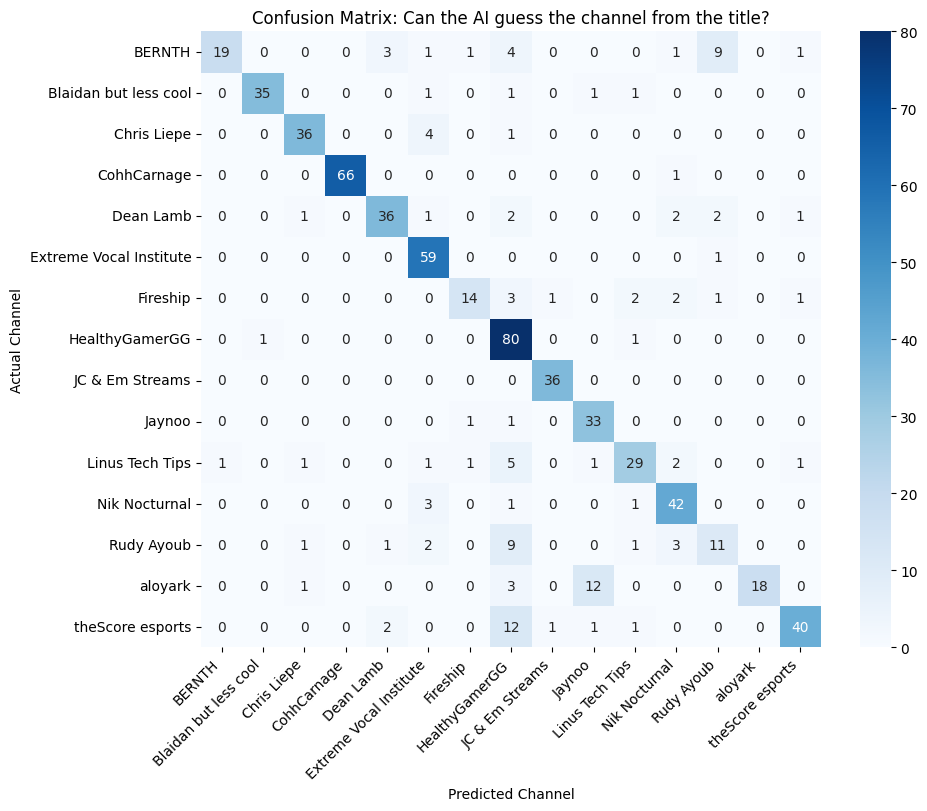

In [72]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, 
            fmt='d', 
            xticklabels=model.classes_, 
            yticklabels=model.classes_,
            cmap='Blues')
plt.ylabel('Actual Channel')
plt.xlabel('Predicted Channel')
plt.title('Confusion Matrix: Can the AI guess the channel from the title?')
plt.xticks(rotation=45, ha='right')
plt.show()

# next video prediction

Total rows in 'df': 38167
Top 10 Channels: ['HealthyGamerGG', 'Extreme Vocal Institute', 'Jaynoo', 'theScore esports', 'Nik Nocturnal', 'CohhCarnage', 'Linus Tech Tips', 'Dean Lamb', 'Chris Liepe', 'Rudy Ayoub']
Rows after filtering for Top 10: 2644


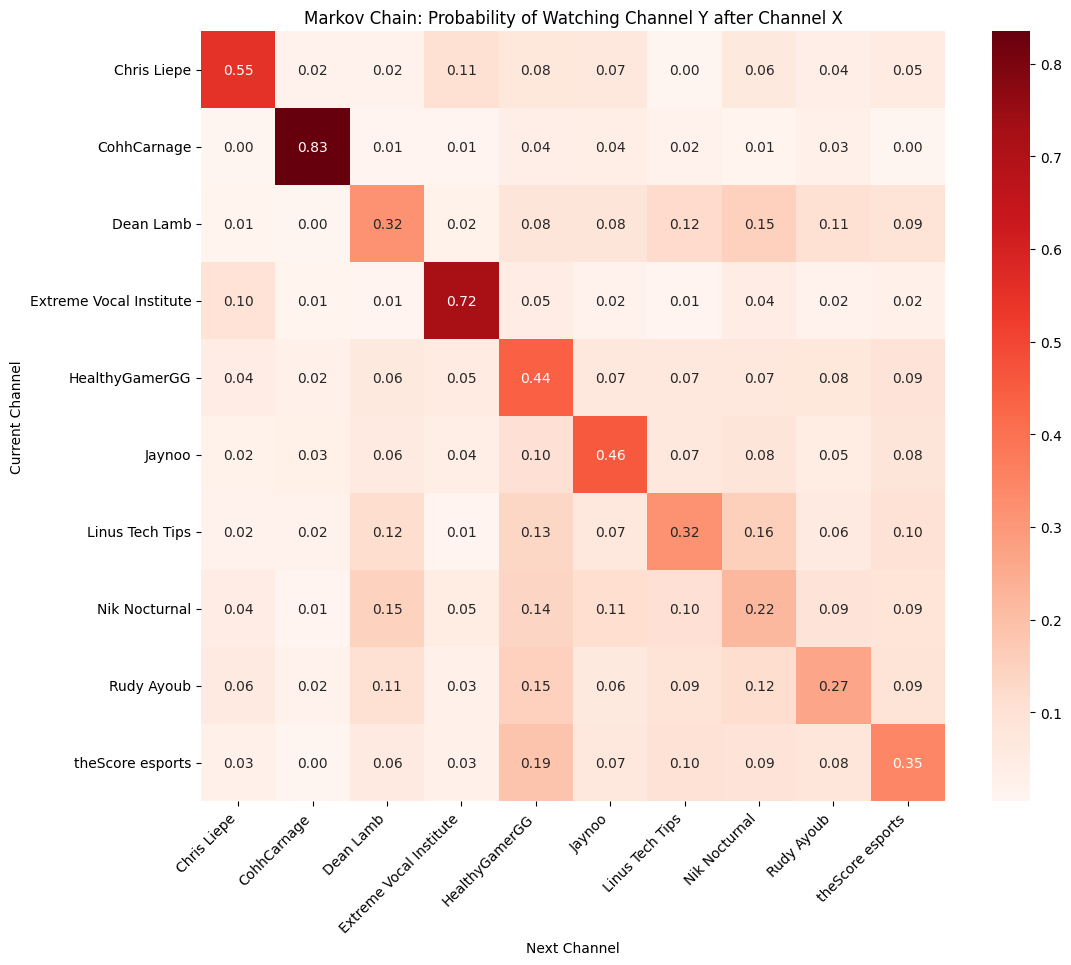


Prediction Test: After HealthyGamerGG, you will likely watch HealthyGamerGG (44.1% chance)


In [73]:
print(f"Total rows in 'df': {len(df)}")

top_10_channels = df['channel_name'].value_counts().head(10).index
print(f"Top 10 Channels: {list(top_10_channels)}")

# Get rows for top 10 channels
df_top = df[df['channel_name'].isin(top_10_channels)].copy()
print(f"Rows after filtering for Top 10: {len(df_top)}")

# Sort by time to ensure sequence is correct
df_top = df_top.sort_values('time')

# Feature engineer the next channel column
df_top['next_channel'] = df_top['channel_name'].shift(-1)

# Last row doesn't have a next channel (because its the last row duh)
df_top = df_top.dropna(subset=['next_channel'])

transition_matrix = pd.crosstab(df_top['channel_name'], df_top['next_channel'], normalize='index')

plt.figure(figsize=(12, 10))
sns.heatmap(transition_matrix, annot=True, fmt='.2f', cmap='Reds')
plt.title('Markov Chain: Probability of Watching Channel Y after Channel X')
plt.ylabel('Current Channel')
plt.xlabel('Next Channel')
plt.xticks(rotation=45, ha='right')
plt.show()

# Function to actually do predictions
def predict_next(current_channel):
    if current_channel not in transition_matrix.index:
        return "Unknown Channel or No Data"
    probs = transition_matrix.loc[current_channel]
    likely_next = probs.idxmax()
    probability = probs.max()
    return f"After {current_channel}, you will likely watch {likely_next} ({probability:.1%} chance)"

# Test
first_channel = top_10_channels[0]
print(f"\nPrediction Test: {predict_next(first_channel)}")

# Predict How Many Videos I Will Watch (Time Series Forecasting)

## Prepare data

In [74]:
# Count number of titles per day
daily_data = df.set_index('time').resample('D')['clean_title'].count().reset_index()
daily_data.columns = ['date', 'video_count']

# Feature engineer the required features
daily_data['day_of_week'] = daily_data['date'].dt.dayofweek  # 0=Mon, 6=Sun
daily_data['month'] = daily_data['date'].dt.month
daily_data['is_weekend'] = daily_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# lag features
daily_data['lag_1'] = daily_data['video_count'].shift(1) # Videos watched on the previous day
daily_data['lag_7'] = daily_data['video_count'].shift(7) # Videos watched on the same day last week

# first 7 rows wouldn't have videos watched last week, so drop them
daily_data = daily_data.dropna()

print(f"Dataset ready: {len(daily_data)} days of history.")
daily_data.head()

Dataset ready: 1635 days of history.


,date,video_count,day_of_week,month,is_weekend,lag_1,lag_7
7,2021-06-10 00:00:00+00:00,9,3,6,0,25.0,20.0
8,2021-06-11 00:00:00+00:00,12,4,6,0,9.0,35.0
9,2021-06-12 00:00:00+00:00,14,5,6,1,12.0,14.0
10,2021-06-13 00:00:00+00:00,24,6,6,1,14.0,21.0
11,2021-06-14 00:00:00+00:00,51,0,6,0,24.0,13.0


## Training and Testing

In [75]:
# features (X) and target (y)
features = ['day_of_week', 'month', 'is_weekend', 'lag_1', 'lag_7']
X = daily_data[features]
y = daily_data['video_count']

# first 80% of the data for training, last 20% for testing
split_index = int(len(daily_data) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error: 18.13
R² Score: 0.04


## Visualization

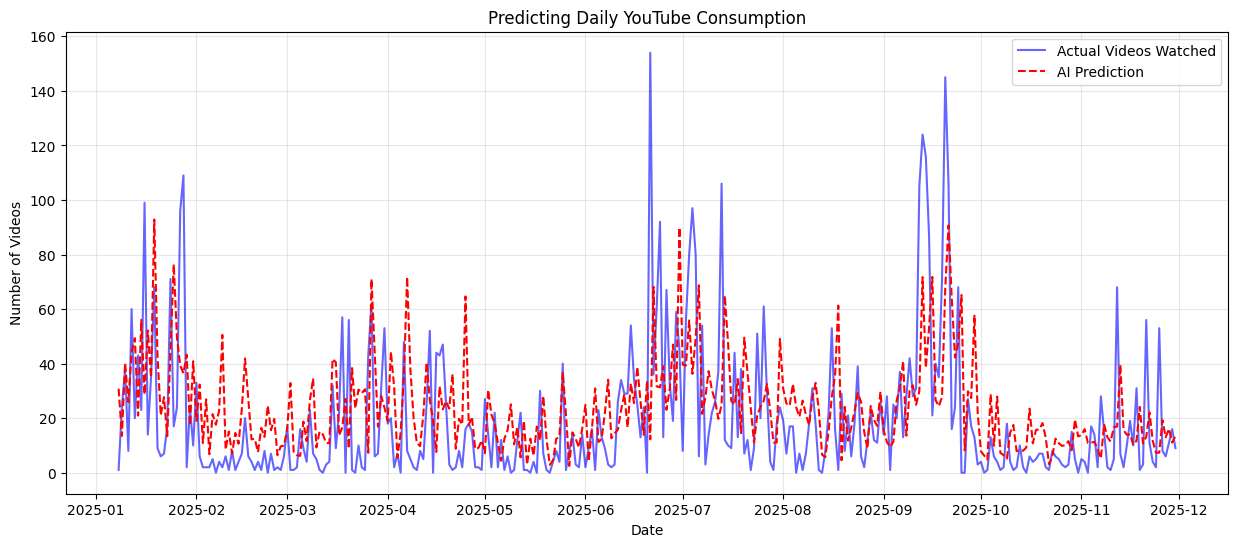

In [76]:
plt.figure(figsize=(15, 6))

# test set data
plt.plot(daily_data['date'].iloc[split_index:], y_test, label='Actual Videos Watched', color='blue', alpha=0.6)

# prediction data
plt.plot(daily_data['date'].iloc[split_index:], y_pred, label='AI Prediction', color='red', linestyle='--')

plt.title('Predicting Daily YouTube Consumption')
plt.xlabel('Date')
plt.ylabel('Number of Videos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

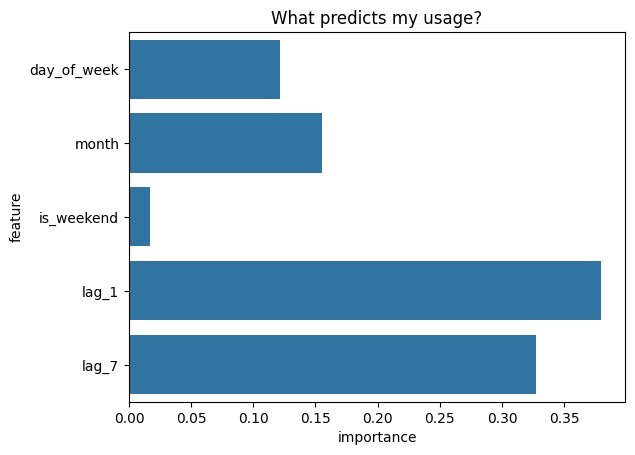

In [66]:
# how important was which feature in determining predictions)
importance = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
sns.barplot(data=importance, x='importance', y='feature')
plt.title('What predicts my usage?')
plt.show()